In [204]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4

print(os.getcwd())


/workspace/src


In [205]:
def compute_sm_from_filename(fn_wav, L=21, H=5, L_smooth=16, tempo_rel_set=np.array([1]),
                             shift_set=np.array([0]), strategy='relative', scale=True, thresh=0.15,
                             penalty=0.0, binarize=False):
     
    # Waveform
    Fs = 22050
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_duration = x.shape[0] / Fs

    # Chroma Feature Sequence and SSM (10 Hz)
    C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=2, hop_length=2205, n_fft=4410)
    Fs_C = Fs / 2205

    # Chroma Feature Sequence and SSM
    X, Fs_feature = libfmp.c3.smooth_downsample_feature_sequence(C, Fs_C, filt_len=L, down_sampling=H)
    X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)

    # Compute SSM
    S, I = libfmp.c4.compute_sm_ti(X, X, L=L_smooth, tempo_rel_set=tempo_rel_set, shift_set=shift_set, direction=2)
    S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy,
                                          scale=scale, penalty=penalty, binarize=binarize)
    return x, x_duration, X, Fs_feature, S_thresh, I

In [206]:
def readSongFile(collection, song, L=81, H=10, L_smooth=1, thresh=1, penalty=0.0):
    fn_wav = os.path.join('..', 'audio', collection, song)
    tempo_rel_set = libfmp.c4.compute_tempo_rel_set( 0.66, 1.5, 5)
    x, x_duration, X, Fs_feature, S, I = compute_sm_from_filename(fn_wav, L=L, H=H, L_smooth=L_smooth, thresh=thresh, penalty=penalty)
    return x, x_duration, X, Fs_feature, S, I

In [208]:
# Waveform
song = '09 - Nirvana - Smells Like Teen Spirit.mp3'
group = 'RS500'
x, x_duration, X, Fs_feature, S, I = readSongFile(group, song)

# penalty = -2
# x, x_duration, X, Fs_feature, S, I = compute_sm_from_filename(fn_wav, L=21, H=10, L_smooth=8, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh=0.15)


In [209]:
# @jit(nopython=True)
def compute_novelty_ssm(S, kernel=None, L=10, var=0.5, exclude=False):
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        S (np.ndarray): SSM
        kernel (np.ndarray): Checkerboard kernel (if kernel==None, it will be computed) (Default value = None)
        L (int): Parameter specifying the kernel size M=2*L+1 (Default value = 10)
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 0.5)
        exclude (bool): Sets the first L and last L values of novelty function to zero (Default value = False)

    Returns:
        nov (np.ndarray): Novelty function
    """
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2*L + 1
    nov = np.zeros(N)
    # np.pad does not work with numba/jit
    S_padded = np.pad(S, L, mode='constant')

    for n in range(N):
        # Does not work with numba/jit
        nov[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    if exclude:
        right = np.min([L, N])
        left = np.max([0, N-L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov



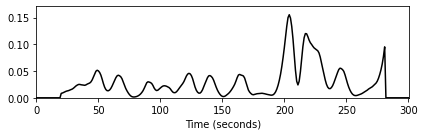

In [210]:
L_kernel = 20
nov = compute_novelty_ssm(S, L=L_kernel, exclude=True)        
fig, ax, line = libfmp.b.plot_signal(nov, Fs=Fs_X, color='k')

# Removed the line that plots annotations overlay
plt.tight_layout()


[204 217 281]


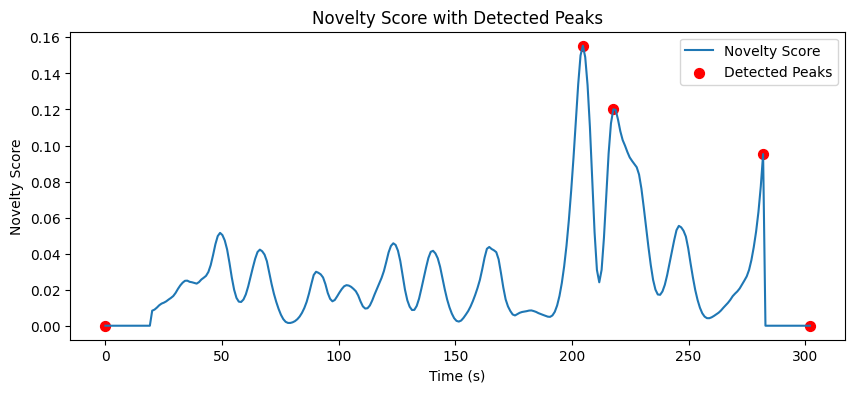

In [211]:
import scipy 

#nov_smoothed = scipy.ndimage.gaussian_filter1d(nov, sigma=1)
peaks = librosa.util.peak_pick(nov, pre_max=3, post_max=3, pre_avg=3, post_avg=3, delta=0.005, wait=10)
print(peaks)

# 'Fs_feature' should be the feature rate or equivalent to ensure correct time scaling
times = np.linspace(0, len(nov) / Fs_feature, len(nov))

# Ensure 'peaks' contains integer indices
peaks = peaks.astype(int)  # Ensures peaks are of integer type, though usually not necessary
# Add start and end indices
peaks = np.hstack(([0], peaks, [len(nov) - 1]))

plt.figure(figsize=(10, 4))
plt.plot(times, nov, label='Novelty Score')
plt.scatter(times[peaks], nov[peaks], color='r', s=50, label='Detected Peaks')  # Plot peaks
plt.xlabel('Time (s)')
plt.ylabel('Novelty Score')
plt.legend()
plt.title('Novelty Score with Detected Peaks')
plt.show()

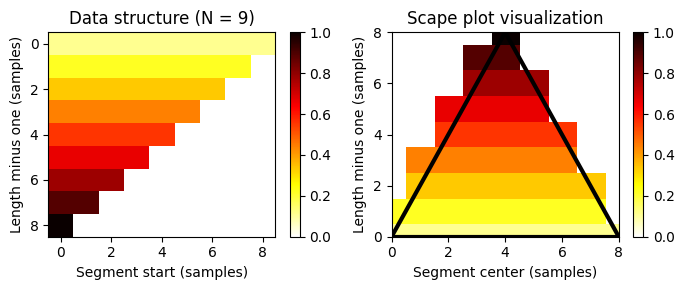

In [212]:
def visualize_scape_plot(SP, Fs=1, ax=None, figsize=(4, 3), title='',
                         xlabel='Center (seconds)', ylabel='Length (seconds)', interpolation='nearest'):
    """Visualize scape plot

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        SP: Scape plot data (encodes as start-duration matrix)
        Fs: Sampling rate (Default value = 1)
        ax: Used axes (Default value = None)
        figsize: Figure size (Default value = (4, 3))
        title: Title of figure (Default value = '')
        xlabel: Label for x-axis (Default value = 'Center (seconds)')
        ylabel: Label for y-axis (Default value = 'Length (seconds)')
        interpolation: Interpolation value for imshow (Default value = 'nearest')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()
    N = SP.shape[0]
    SP_vis = np.zeros((N, N))
    for length_minus_one in range(N):
        for start in range(N-length_minus_one):
            center = start + length_minus_one//2
            SP_vis[length_minus_one, center] = SP[length_minus_one, start]

    extent = np.array([-0.5, (N-1)+0.5, -0.5, (N-1)+0.5]) / Fs
    im = plt.imshow(SP_vis, cmap='hot_r', aspect='auto', origin='lower', extent=extent, interpolation=interpolation)
    x = np.asarray(range(N))
    x_half_lower = x/2
    x_half_upper = x/2 + N/2 - 1/2
    plt.plot(x_half_lower/Fs, x/Fs, '-', linewidth=3, color='black')
    plt.plot(x_half_upper/Fs, np.flip(x, axis=0)/Fs, '-', linewidth=3, color='black')
    plt.plot(x/Fs, np.zeros(N)/Fs, '-', linewidth=3, color='black')
    plt.xlim([0, (N-1) / Fs])
    plt.ylim([0, (N-1) / Fs])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.colorbar(im, ax=ax)
    return fig, ax, im

N = 9
SP = np.zeros((N,N))
for k in range(N):
    for s in range(N-k):
        length = k + 1
        SP[k, s]= length/N  

plt.figure(figsize=(7,3))
ax = plt.subplot(121)
plt.imshow(SP, cmap='hot_r', aspect='auto') 
ax.set_title('Data structure (N = %d)'%N)
ax.set_xlabel('Segment start (samples)')
ax.set_ylabel('Length minus one (samples)')
plt.colorbar()  

ax = plt.subplot(122)
fig, ax, im = visualize_scape_plot(SP, Fs=1, ax=ax, title='Scape plot visualization', 
                xlabel='Segment center (samples)', ylabel='Length minus one (samples)')

/tmp/ipykernel_392157/2472274405.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(labels))  # Adjust len(labels) as needed


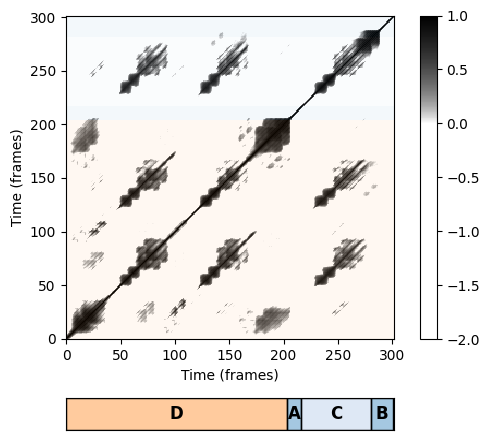

In [224]:
import os
import libfmp.c4

# Assuming compute_sm_from_filename and normalization_properties_ssm are defined elsewhere
song = '09 - Nirvana - Smells Like Teen Spirit.mp3'
group = 'RS500'
x, x_duration, X, Fs_feature, S, I = readSongFile(group, song, 45, 10, 8, 0.15, -2)

S = libfmp.c4.normalization_properties_ssm(S)

# Calculate segment lengths
segment_lengths = np.diff(peaks)

# Sort segments by length to assign labels
sorted_indices = np.argsort(segment_lengths)
labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"  # Extend this string if you have more than 26 segments

# Assign labels based on sorted order of lengths
label_assignments = {index: labels[i] for i, index in enumerate(sorted_indices)}

# Now, create ann_frames with labels based on their lengths
ann_frames = [(peaks[i], peaks[i+1], label_assignments[i]) for i in range(len(peaks)-1)]
# Color definitions: 
colormap = plt.cm.get_cmap('tab20', len(labels))  # Adjust len(labels) as needed

# Assign colors to labels
color_ann = {label: colormap(i)[:3] + (0.4,) for i, label in enumerate(labels)}

# Plotting the self-similarity matrix with annotations
cmap_penalty = libfmp.c4.colormap_penalty(penalty=penalty)
fig, ax, im = libfmp.c4.plot_ssm_ann(S, ann_frames, Fs=1, color_ann=color_ann, cmap=cmap_penalty, 
                       xlabel='Time (frames)', ylabel='Time (frames)')


In [217]:
# @jit(nopython=True)
def compute_fitness_scape_plot(S):
    """Compute scape plot for fitness and other measures

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        S (np.ndarray): Self-similarity matrix

    Returns:
        SP_all (np.ndarray): Vector containing five different scape plots for five measures
            (fitness, score, normalized score, coverage, normlized coverage)
    """
    N = S.shape[0]
    SP_fitness = np.zeros((N, N))
    SP_score = np.zeros((N, N))
    SP_score_n = np.zeros((N, N))
    SP_coverage = np.zeros((N, N))
    SP_coverage_n = np.zeros((N, N))

    for length_minus_one in range(N):
        for start in range(N-length_minus_one):
            S_seg = S[:, start:start+length_minus_one+1]
            D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
            path_family = libfmp.c4.compute_optimal_path_family(D)
            fitness, score, score_n, coverage, coverage_n, path_family_length = libfmp.c4.compute_fitness(
                path_family, score, N)
            SP_fitness[length_minus_one, start] = fitness
            SP_score[length_minus_one, start] = score
            SP_score_n[length_minus_one, start] = score_n
            SP_coverage[length_minus_one, start] = coverage
            SP_coverage_n[length_minus_one, start] = coverage_n
    SP_all = [SP_fitness, SP_score, SP_score_n, SP_coverage, SP_coverage_n]
    return SP_all

In [218]:
def plot_seg_in_sp(ax, seg, S=None, Fs=1):
    """Plot segment and induced segements as points in SP visualization

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        ax: Axis for image
        seg: Segment ``(start_index, end_index)``
        S: Self-similarity matrix (Default value = None)
        Fs: Sampling rate (Default value = 1)
    """
    if S is not None:
        S_seg = S[:, seg[0]:seg[1]+1]
        D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
        path_family = libfmp.c4.compute_optimal_path_family(D)
        segment_family, coverage = libfmp.c4.compute_induced_segment_family_coverage(path_family)
        length = segment_family[:, 1] - segment_family[:, 0] + 1
        center = segment_family[:, 0] + length//2
        ax.scatter(center/Fs, length/Fs, s=64, c='white', zorder=9999)
        ax.scatter(center/Fs, length/Fs, s=16, c='lime', zorder=9999)
    length = seg[1] - seg[0] + 1
    center = seg[0] + length//2
    ax.scatter(center/Fs, length/Fs, s=64, c='white', zorder=9999)
    ax.scatter(center/Fs, length/Fs, s=16, c='blue', zorder=9999)

def plot_sp_ssm(SP, seg, S, ann, color_ann=[], title='', figsize=(5, 4)):
    """Visulization of SP and SSM

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        SP: Scape plot
        seg: Segment ``(start_index, end_index)``
        S: Self-similarity matrix
        ann: Annotation
        color_ann: color scheme used for annotations (Default value = [])
        title: Title of figure (Default value = '')
        figsize: Figure size (Default value = (5, 4))
    """
    float_box = libfmp.b.FloatingBox()
    fig, ax, im = visualize_scape_plot(SP, figsize=figsize, title=title,
                                       xlabel='Center (frames)', ylabel='Length (frames)')
    plot_seg_in_sp(ax, seg, S)
    float_box.add_fig(fig)

    penalty = np.min(S)
    cmap_penalty = libfmp.c4.colormap_penalty(penalty=penalty)
    fig, ax, im = libfmp.c4.plot_ssm_ann_optimal_path_family(
        S, ann, seg, color_ann=color_ann, fontsize=8, cmap=cmap_penalty, figsize=(4, 4),
        ylabel='Time (frames)')
    float_box.add_fig(fig)
    float_box.show()

In [219]:
def seg_max_sp(SP):
    """Return segment with maximal value in SP

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        SP (np.ndarray): Scape plot

    Returns:
        seg (tuple): Segment ``(start_index, end_index)``
    """
    N = SP.shape[0]
    # value_max = np.max(SP)
    arg_max = np.argmax(SP)
    ind_max = np.unravel_index(arg_max, [N, N])
    seg = [ind_max[1], ind_max[1]+ind_max[0]]
    return seg


In [220]:
import os
import json
import numpy as np
# Assuming libfmp and other necessary imports are defined elsewhere

def check_segment(seg, S, collection, name = 'segment_analysis', verbose = False):
    filename =  name + '.json'
    N = S.shape[0]
    S_seg = S[:, seg[0]:seg[1]+1]
    D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
    path_family = libfmp.c4.compute_optimal_path_family(D)
    fitness, score, score_n, coverage, coverage_n, path_family_length = libfmp.c4.compute_fitness(path_family, score, N)
    segment_family, coverage2 = libfmp.c4.compute_induced_segment_family_coverage(path_family)

    if verbose:
        print('Segment (alpha):', seg)
        print('Length of segment:', seg[-1]-seg[0]+1)
        print('Length of feature sequence:', N)
        print('Induced segment path family:\n', segment_family)
        print('Fitness: %0.10f' % fitness)
        print('Score: %0.10f' % score)
        print('Normalized score: %0.10f' % score_n)
        print('Coverage: %d, %d' % (coverage, coverage2))
        print('Normalized coverage: %0.10f' % coverage_n)
        print('Length of all paths of family: %d' % path_family_length)

    # Convert numpy array to a list of lists for JSON compatibility
    segment_family_list = segment_family.tolist()

    # Ensure all numbers are in a JSON serializable format (Python native types)
    data = {
        'Segment': list(map(int, seg)),
        'Length of segment': int(seg[-1] - seg[0] + 1),
        'Length of feature sequence': int(N),
        'Induced segment path family': segment_family_list,
        'Fitness': float(fitness),
        'Score': float(score),
        'Normalized score': float(score_n),
        'Coverage': [int(coverage), int(coverage2)],
        'Normalized coverage': float(coverage_n),
        'Length of all paths of family': int(path_family_length)
    }

    # Define the path where the JSON file will be saved
   
    folder_path = os.path.join('..', 'data', collection)  # Adjust this path as needed
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # Create the folder if it doesn't exist
    file_path = os.path.join(folder_path, filename)

    # Writing data to a JSON file
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

    #print(f'Data saved to JSON file: {file_path}')
    return path_family



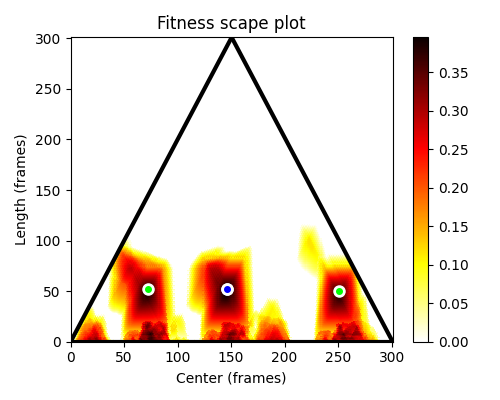
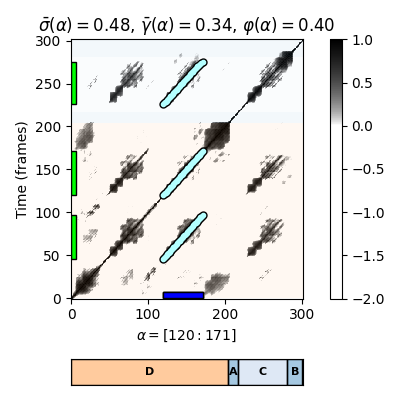

Segment (alpha): [120, 171]
Length of segment: 52
Length of feature sequence: 302
Induced segment path family:
 [[ 46  97]
 [120 171]
 [226 275]]
Fitness: 0.3957003793
Score: 125.5594433793
Normalized score: 0.4776587232
Coverage: 154, 154
Normalized coverage: 0.3377483444
Length of all paths of family: 154


In [225]:
SP_all = compute_fitness_scape_plot(S)

SP = SP_all[0]
seg = seg_max_sp(SP)
figsize=(5,4)

plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Fitness scape plot', figsize=figsize)
path_family = check_segment(seg, S, 'Boomy500', song_name, True)

In [159]:
import os

# folder path
dir_path = '../audio/RS500/'

# list to store files
tracks = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        tracks.append(path)

for t in tracks:
    if t == '.DS_Store':
        tracks.remove(t)
        
tracks.sort()
print(len(tracks))

500


In [228]:
from tqdm import tqdm
 
group = 'RS500'
L_kernel = 20

for song in tqdm(tracks):
    try:
        x, x_duration, X, Fs_feature, S, I = readSongFile(group, song, 45, 10, 8, 0.15, -2)
        S = libfmp.c4.normalization_properties_ssm(S)

        #compute SP
        SP_all = compute_fitness_scape_plot(S)
        
        SP = SP_all[0]
        seg = seg_max_sp(SP)
        path_family = check_segment(seg, S, group, song)
    except:
        print('Error with song:', song)
        continue
    


  0%|          | 0/500 [00:00<?, ?it/s]

  2%|▏         | 10/500 [01:58<2:25:20, 17.80s/it]